# Project Report (Group 93)
## Water Potability



### Methods & Results

- Q. describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
(https://www.kaggle.com/datasets/adityakadiwal/water-potability) 

### Exploratory Data Analysis

In [14]:
library(tidyverse)
# library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

In [15]:
set.seed(2023)
options(repr.plot.width = 8, repr.plot.height = 7)
#1. READ DATA
url <- "https://raw.githubusercontent.com/Swapnil-Dubey/Dsci100_Group93_/main/data/water_potability.csv"
water_potability_raw <- read_csv(url) #unedited "raw" dataset

print(paste("Number of rows in the table: ",nrow(water_potability_raw))) #show number of observations in the raw dataset.
print(paste("Number of columns in the table: ",ncol(water_potability_raw))) #show number of variables in the raw dataset.

head(water_potability_raw)

Rows: 3276 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Number of rows in the table:  3276"
[1] "Number of columns in the table:  10"


ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,204.8905,20791.32,7.300212,368.5164,564.3087,10.379783,86.99097,2.963135,0
3.716080,129.4229,18630.06,6.635246,NA,592.8854,15.180013,56.32908,4.500656,0
8.099124,224.2363,19909.54,9.275884,NA,418.6062,16.868637,66.42009,3.055934,0
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0


<center> (Figure 1: Original water potability dataset) </center>

<hr noshade>
<tt>
Before we move on to the classification component, it is always required that we take a look at our data and understand the problem and the structure of the data and clean the data if necessary. 
    <br> </br>
    
Here you can notice that the predictive variable i.e <i>Potability</i> is of numeric type, however it only takes up the value 0 or 1 and hence we use `as.factor()` to convert it into a factor. <br>
Furthermore, we don't want our data to contain any `NA` values, and hence we will ignore those values using `na.omit()`
</tt>

In [16]:
#2. CLEAN DATA AND REMOVE NA ROWS
water_potability_clean <- water_potability_raw |>
    rename(hardness = Hardness, solids = Solids, chloramines = Chloramines, sulfate = Sulfate, conductivity = Conductivity, organic_carbon = Organic_carbon, trihalomethanes = Trihalomethanes, turbidity = Turbidity, potability = Potability) |>
    mutate(potability = as_factor(potability)) |>
    na.omit()

print(paste("Number of rows in the table: ",nrow(water_potability_clean))) #number of observations in the cleaned dataset (NA removed)
print(paste("Number of columns in the table: ",ncol(water_potability_clean))) #number of variables in the cleaned dataset (NA removed)

head(water_potability_clean)

[1] "Number of rows in the table:  2011"
[1] "Number of columns in the table:  10"


ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0
10.223862,248.0717,28749.72,7.513408,393.6634,283.6516,13.789695,84.60356,2.672989,0
8.635849,203.3615,13672.09,4.563009,303.3098,474.6076,12.363817,62.79831,4.401425,0
11.180284,227.2315,25484.51,9.077200,404.0416,563.8855,17.927806,71.97660,4.370562,0


<center> (Figure 2: Clean water potability dataset) </center>

<hr noshade>

The next step is to divide the data into training and testing dataset after selecting a predictive question to answer and wrangling the data. We split it in the ratio 3:1 (training: 75% , testing: 25%) 
    
The `initial_split` function from `tidymodels` library splits the data for us.
    

In [17]:
#3. CREATE TRAINING DATA and TESTING DATA
water_split <- water_potability_clean |> #split the data 0.75/0.25
    initial_split(prop = 0.75, strata = potability) 


water_train <- training(water_split)  #set the 0.75 split as the training data
water_test <- testing(water_split) #set the 0.25 split as the testing data

head(water_train)

ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.55828,31.99799,4.075075,0
8.635849,203.3615,13672.09,4.563009,303.3098,474.6076,12.36382,62.79831,4.401425,0
11.180284,227.2315,25484.51,9.077200,404.0416,563.8855,17.92781,71.97660,4.370562,0
7.360640,165.5208,32452.61,7.550701,326.6244,425.3834,15.58681,78.74002,3.662292,0
7.119824,156.7050,18730.81,3.606036,282.3441,347.7150,15.92954,79.50078,3.445756,0
6.347272,186.7329,41065.23,9.629596,364.4877,516.7433,11.53978,75.07162,4.376348,0


<center> (Figure 3: Training water potability dataset) </center>

<hr noshade> 

Here we are trying to analyze the data i.e finding the mean of all the predictor variables for each group (potable and non-potable) <br>

We use `summarize()` and `group_by` to find the means of all the predictor variables and count the number of observations for each group.
   

In [18]:
#4. SUMMARIZE DATA IN A TABLE
water_train_means <- water_train |> #find means for all predictors grouped by potability
    group_by(potability) |>
    summarize(across(ph:turbidity, mean, na.rm=TRUE))

water_train_nrows <- water_train |> #count number of observations in the two groups
    group_by(potability) |>
    summarize(n = n())

water_train_summary <- water_train_means |> #merge grouped n dataframe with grouped means dataframe
    merge(water_train_nrows)

water_train_summary

potability,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,7.041711,196.2666,21591.49,7.102538,334.1355,427.0587,14.43886,65.94446,3.969137,900
1,7.123942,196.7239,22352.82,7.195704,331.1790,422.0726,14.38643,66.82991,3.984172,608


<center> (Figure 4: Summarizing our water potability dataset to <br> find the mean of all the variables for each potability value) </center>

<hr noshade>

Let us get a summary of our data using the `summary()` function. This gives us the minimum, maximum, mean, median and quantile values. <br>
Quantile value determines what a fraction of the data looks like. For example the 1st quantile value for ph tells us that 25% of the data lies below 6.0767. <br>
<i>Note:</i> We do not remove the outliers from our data because they hold a meaning. For example a value as low as 320.9 in solids isn't considered as an outlier because it corresponds to less number of minerals present in that particular sample of water.

In [19]:
summary_water_potability <- summary(water_train)
summary_water_potability

       ph             hardness          solids         chloramines    
 Min.   : 0.2275   Min.   : 73.49   Min.   :  320.9   Min.   : 1.391  
 1st Qu.: 6.0767   1st Qu.:177.55   1st Qu.:15585.0   1st Qu.: 6.164  
 Median : 7.0422   Median :198.08   Median :20844.8   Median : 7.145  
 Mean   : 7.0749   Mean   :196.45   Mean   :21898.5   Mean   : 7.140  
 3rd Qu.: 8.0515   3rd Qu.:216.66   3rd Qu.:27165.8   3rd Qu.: 8.144  
 Max.   :14.0000   Max.   :317.34   Max.   :56488.7   Max.   :13.127  
    sulfate       conductivity   organic_carbon  trihalomethanes  
 Min.   :129.0   Min.   :201.6   Min.   : 2.20   Min.   :  8.577  
 1st Qu.:306.8   1st Qu.:363.9   1st Qu.:12.17   1st Qu.: 55.691  
 Median :332.5   Median :422.2   Median :14.32   Median : 66.672  
 Mean   :332.9   Mean   :425.0   Mean   :14.42   Mean   : 66.301  
 3rd Qu.:360.3   3rd Qu.:481.0   3rd Qu.:16.84   3rd Qu.: 77.137  
 Max.   :481.0   Max.   :753.3   Max.   :27.01   Max.   :124.000  
   turbidity     potability
 Min. 

<center> (Figure 5: Summary of our water potability dataset) </center>

<hr noshade>

We now want to check for the number of predictor variables necessary for our model. For that purpose we find the correlation between each predictor variables. <br>
The `ggpairs()` function from `GGally` library helps us do so by visualizing the correlation between them. <br>
Here we find that none of the predictor variables are strongly related with each other and hence we decide to take all the variables into consideration when building our model. <br>
<i>Note:</i> Weak correlation corresponds to a value closer to 0 while a strong correlation has the correlation value closer to 1 or -1.

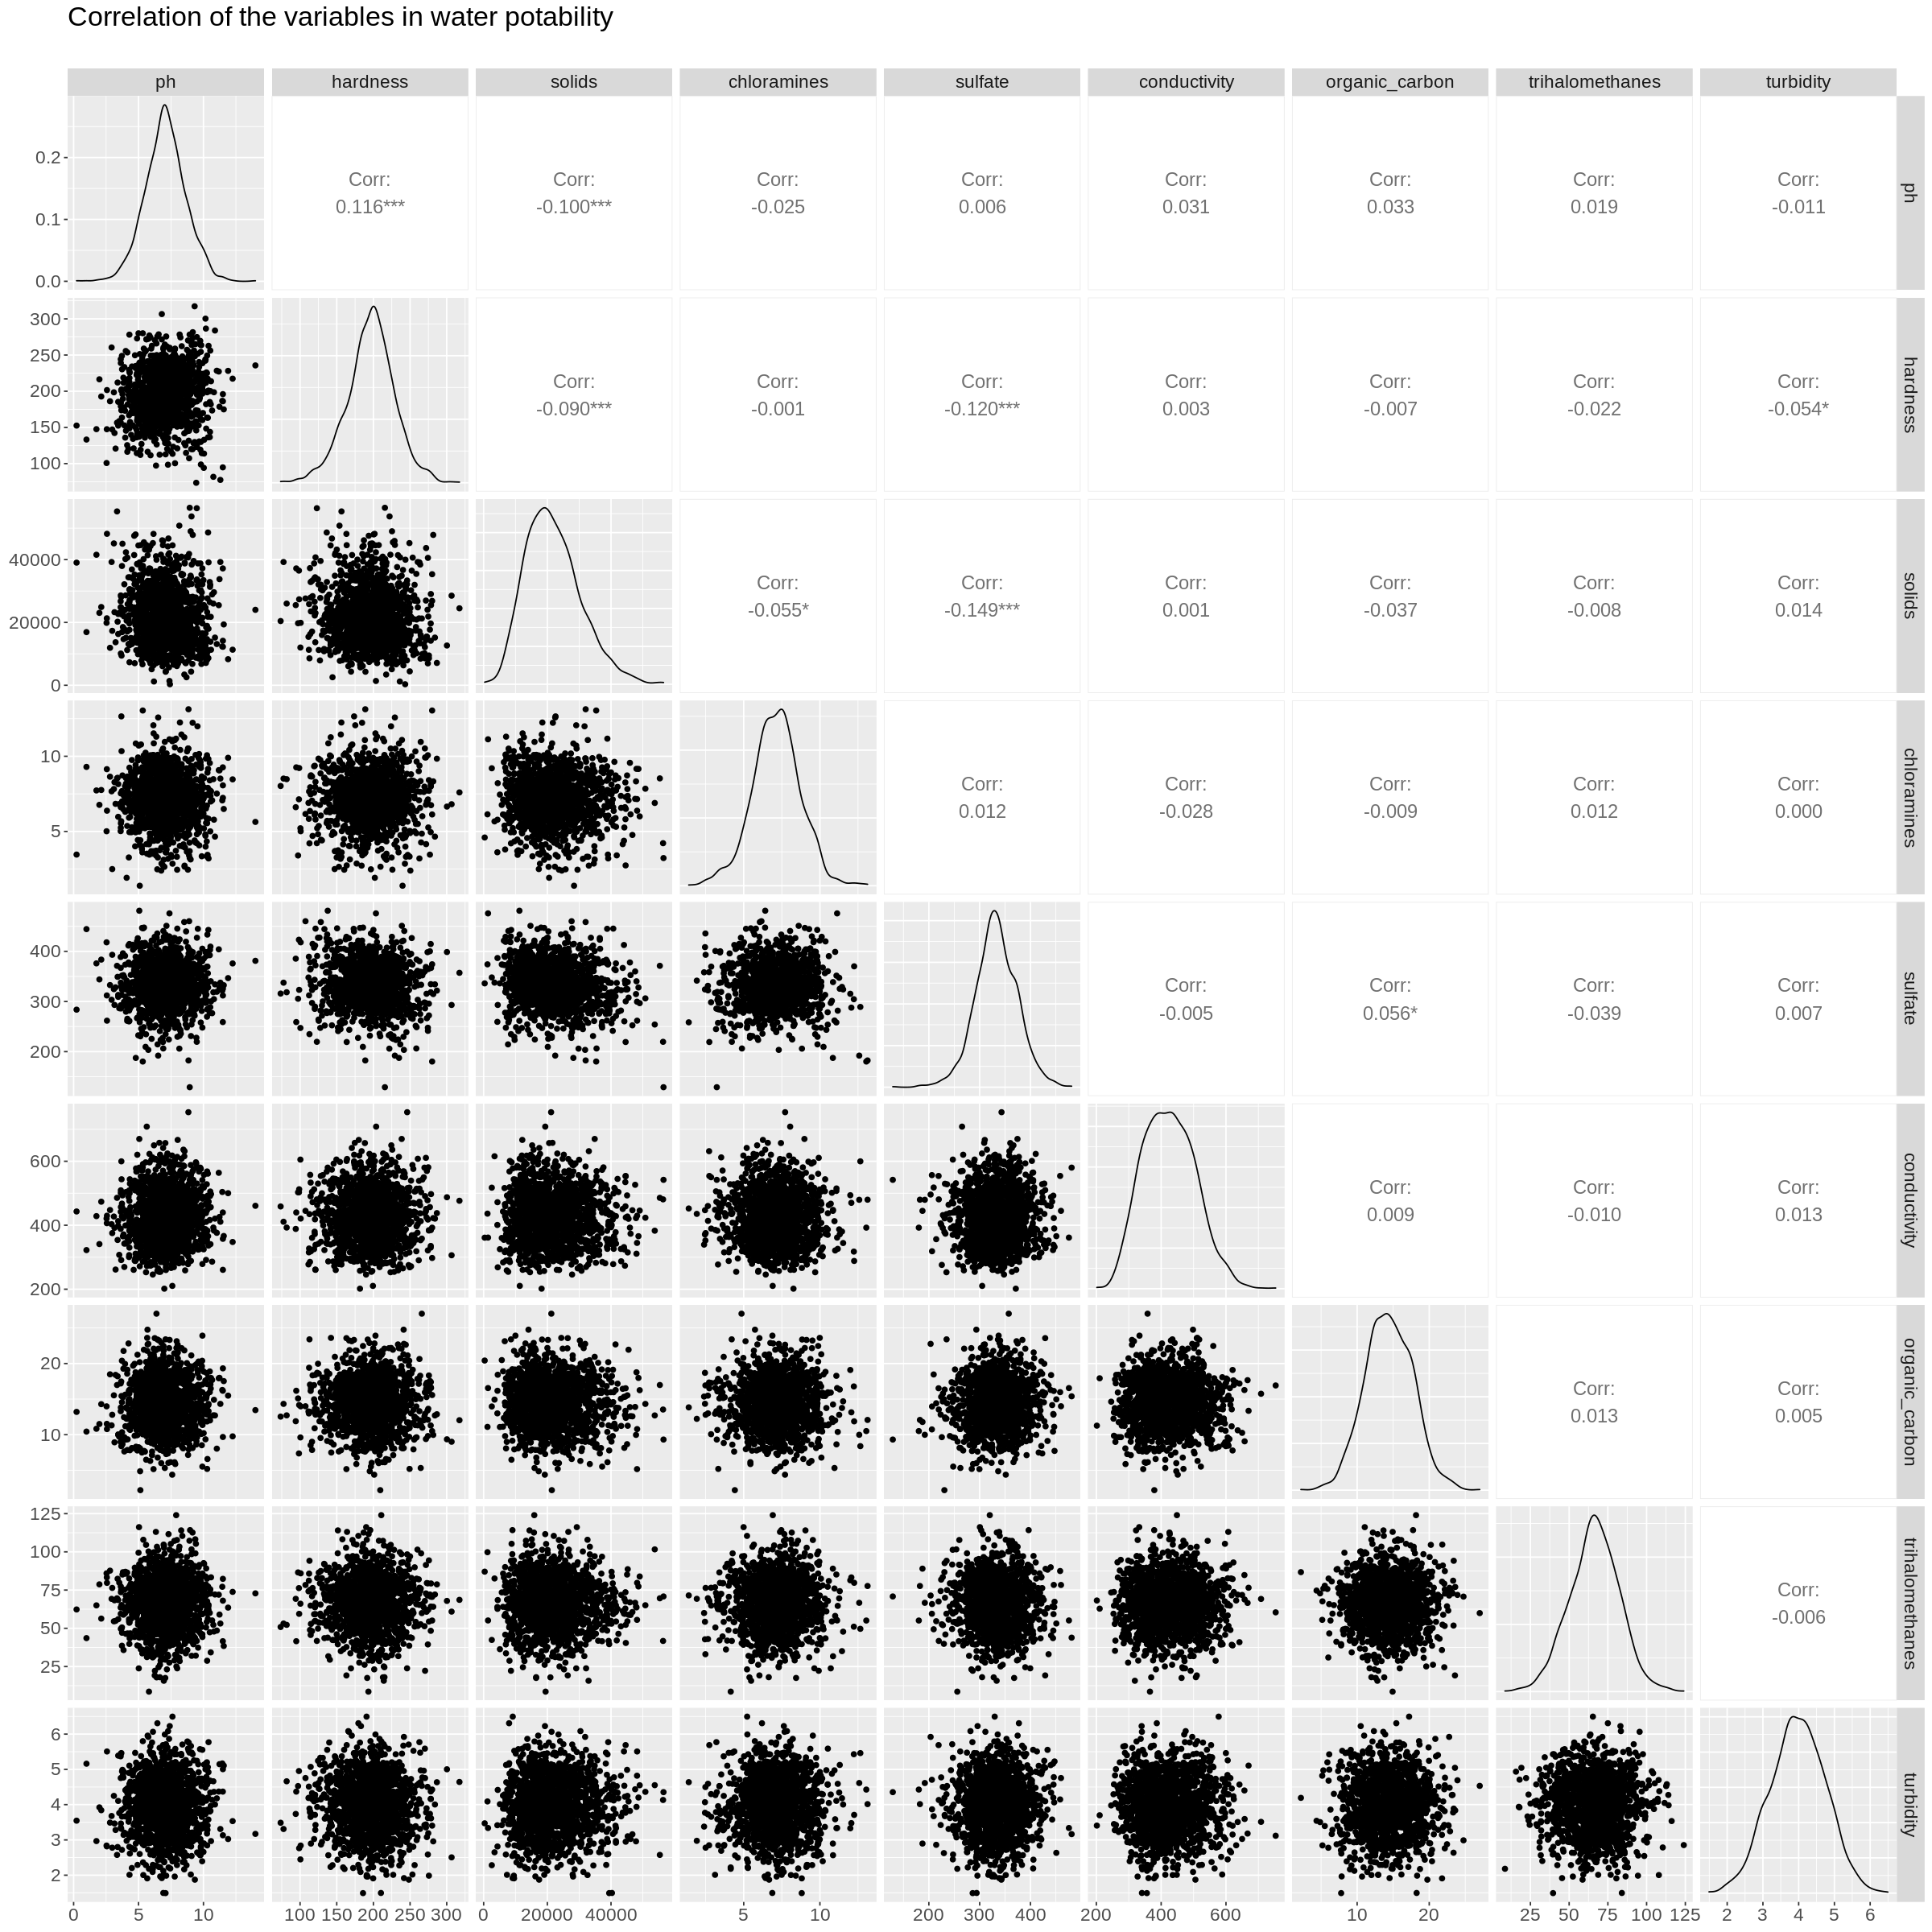

In [20]:
options(repr.plot.width = 20, repr.plot.height = 20)

water_eda <- water_train |>
    select(-potability)|>
    ggpairs(title = "Correlation of the variables in water potability \n",upper = list(continuous = wrap("cor", size = 5))) + theme(text = element_text(size = 17))

water_eda

<center> (Figure 6: Correlation of the variables in water potability) </center>

<hr noshade>

Whenever using K-nearest neighbor classification scaling matters (size and range of each variable). This is because any variables with a large scale will have a much larger effect than variables with a small scale because the classifier predicts classes by identifying observations closest to them. <br>
We normally scale the data when creating the knn-model recipe using `step_scale()` and `step_center()`.

In [21]:
#5. SCALE TRAINING DATA (0 to 1)
min_table <- water_train |> #min value of all predictors
    select(-potability) |>
    map_df(min)

max_table <- water_train |> #max value of all predictors
    select(-potability) |>
    map_df(max)

diff_table <- max_table - min_table #max - min for all predictors

water_train_scaled <- water_train |> #scale all predictors X (0 to 1) according to (Xi - Xmin)/(Xmax - Xmin)
    select(-potability) |>
    mutate(ph = (ph - min_table$ph) / diff_table$ph, 
           hardness = (hardness - min_table$hardness) / diff_table$hardness,
           solids = (solids - min_table$solids) / diff_table$solids, 
           chloramines = (chloramines - min_table$chloramines) / diff_table$chloramines,
           sulfate = (sulfate - min_table$sulfate) / diff_table$sulfate, 
           conductivity = (conductivity - min_table$conductivity) / diff_table$conductivity,
           organic_carbon = (organic_carbon - min_table$organic_carbon) / diff_table$organic_carbon, 
           trihalomethanes = (trihalomethanes - min_table$trihalomethanes) / diff_table$trihalomethanes,
           turbidity = (turbidity - min_table$turbidity) / diff_table$turbidity) |>
    bind_cols(potability = water_train$potability)

head(water_train_scaled)

ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.6436539,0.4413003,0.3143806,0.4393041,0.5145454,0.3566846,0.3772480,0.2029143,0.5163113,0
0.6105173,0.5325876,0.2377014,0.2702882,0.4951551,0.4947917,0.4097205,0.4697617,0.5815480,0
0.7952648,0.6304770,0.4480075,0.6549288,0.7813003,0.6566082,0.6340143,0.5492804,0.5753785,0
0.5179263,0.3774046,0.5720664,0.5248605,0.5613840,0.4055726,0.5396448,0.6078772,0.4337965,0
0.5004411,0.3412514,0.3277660,0.1887475,0.4355986,0.2647983,0.5534606,0.6144683,0.3905114,0
0.4443472,0.4643943,0.7254039,0.7019968,0.6689409,0.5711627,0.3765023,0.5760950,0.5765352,0


<center> (Figure 7: Scaled water potability dataset) </center>

<hr noshade>

We visualize the the means of each predictor variables grouped by each of the potability type in order to compare and analyze the trend <br>
Here we make use of the `ggplot()` function from the `ggplot2` package which has already been loaded by the `tidyverse` package.

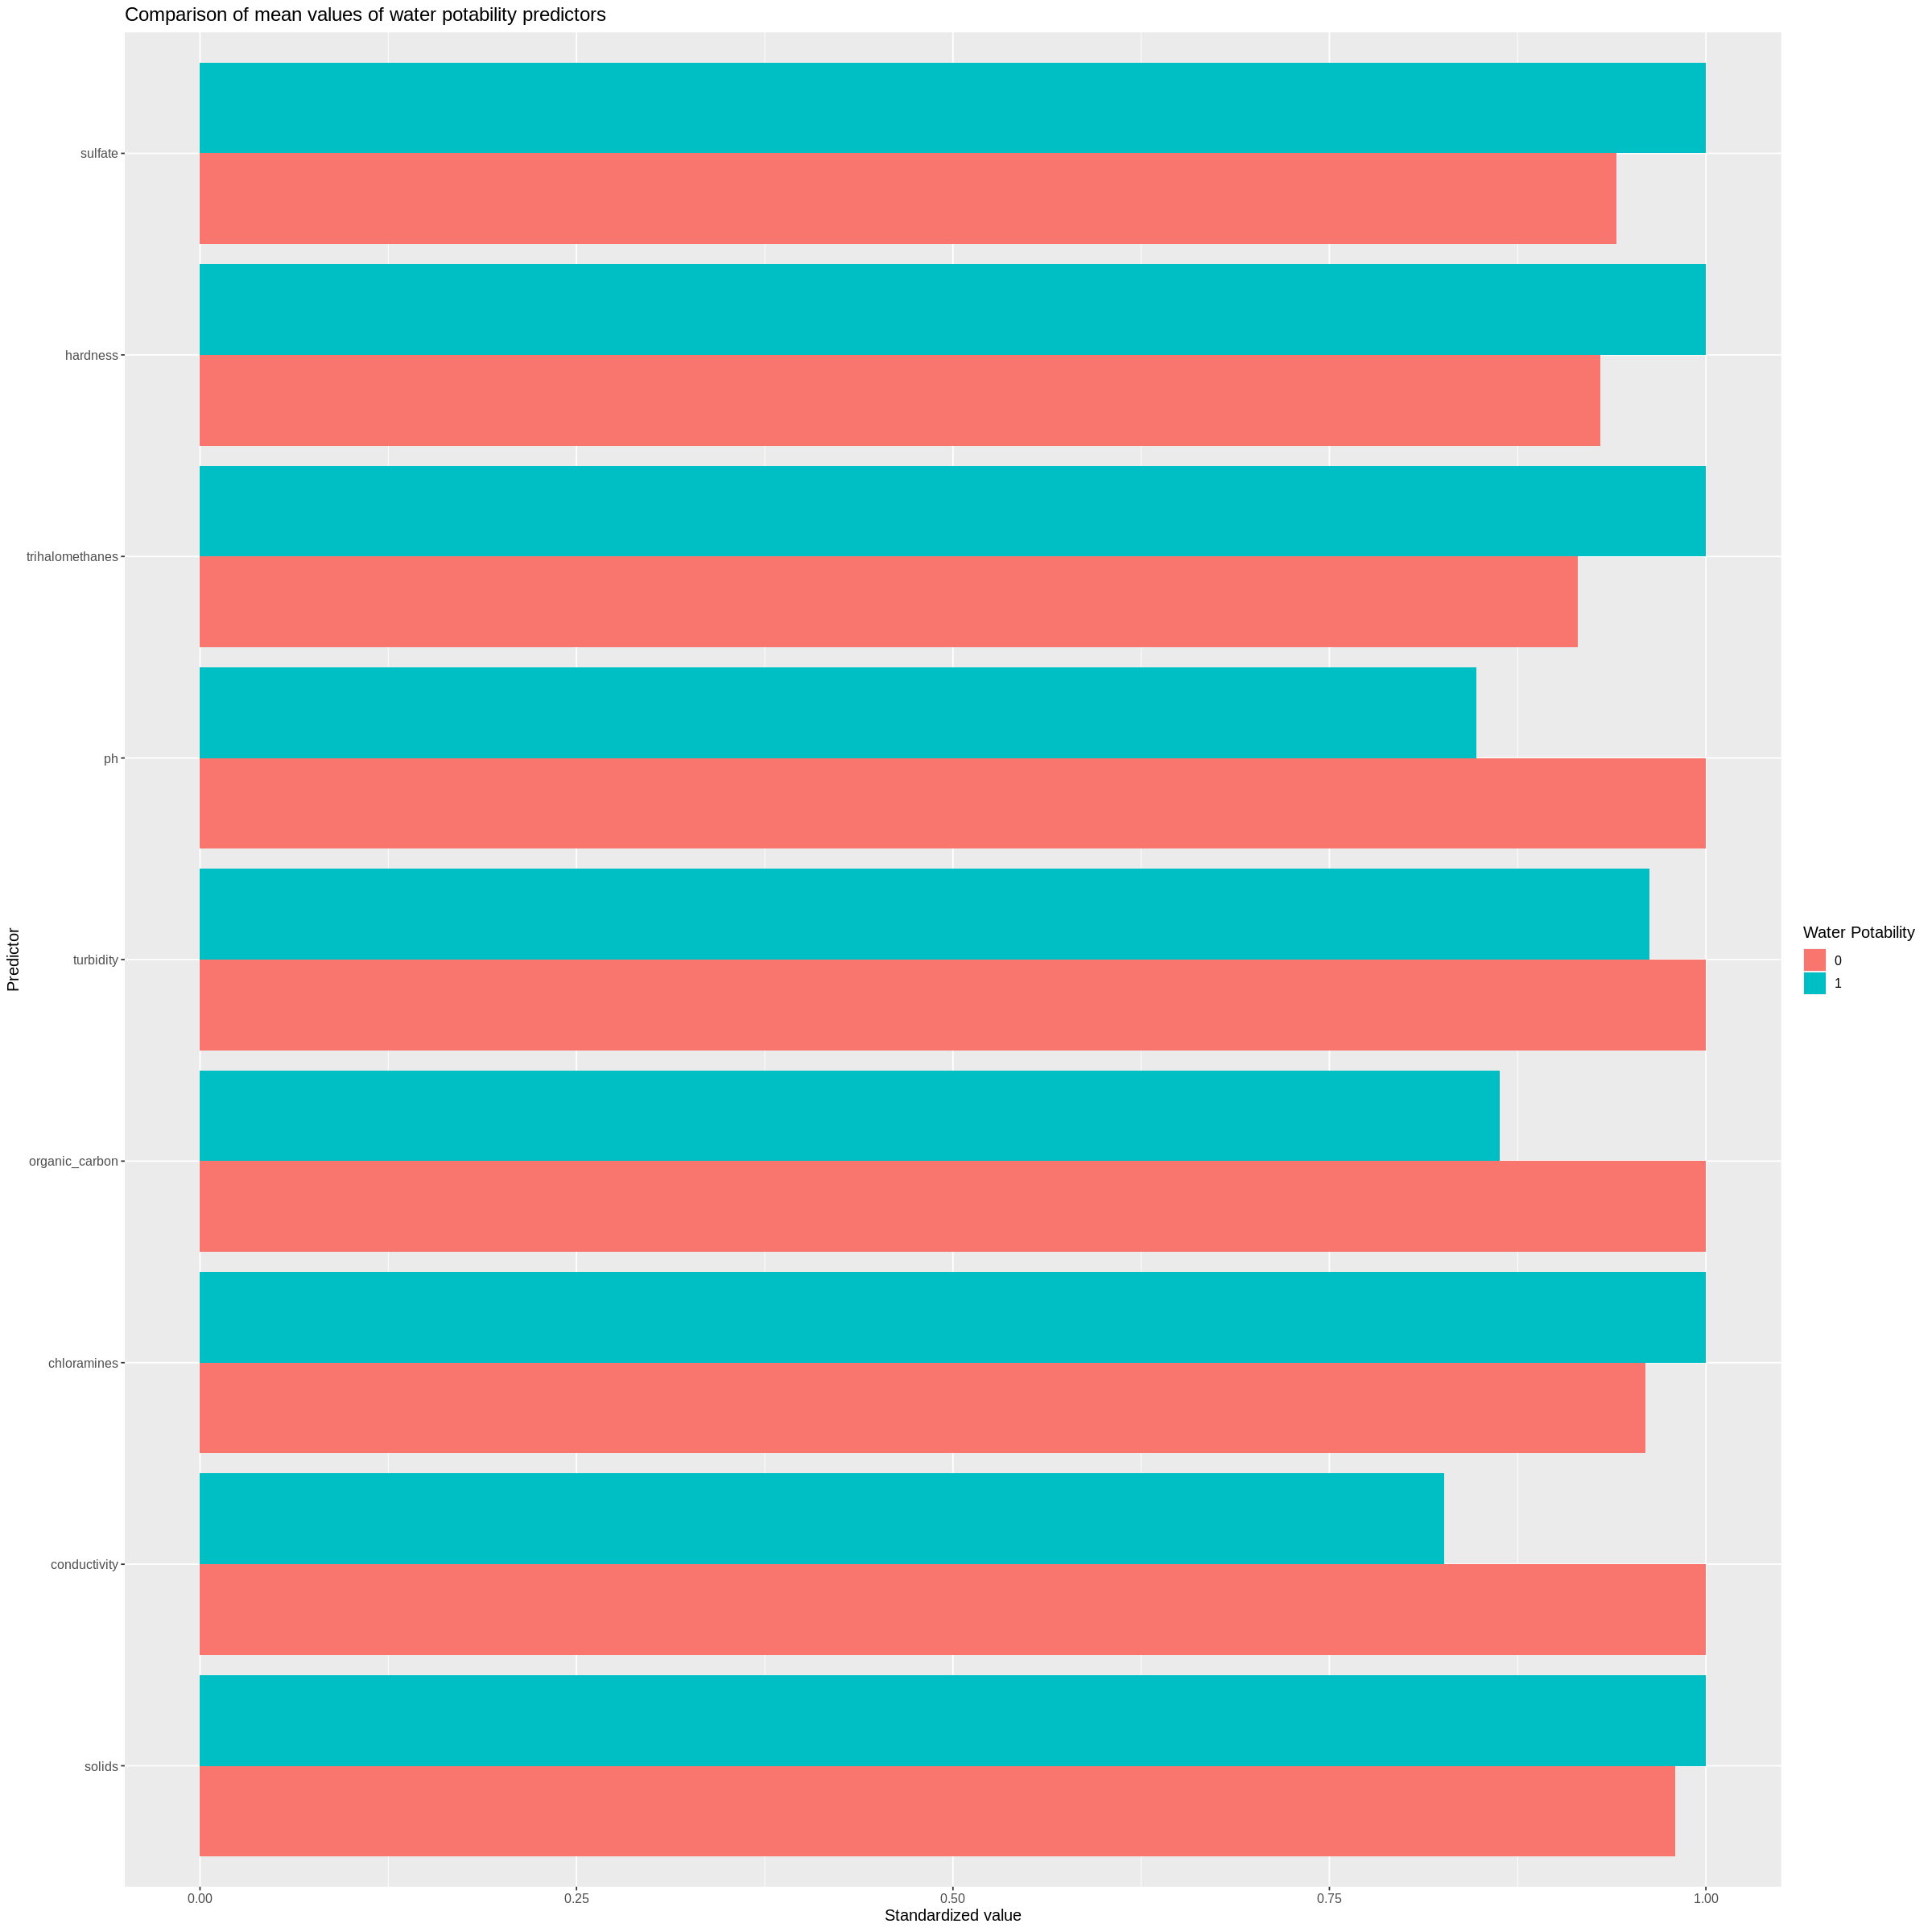

In [22]:
#6. PLOT SCALED TRAINING DATA (0-1) IN A BARPLOT SHOWING MEANS OF EACH PREDICTOR
water_train_scaled_longer <- water_train_scaled |> #pivot longer, generating columns "predictor" and "value"
    pivot_longer(c(ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, trihalomethanes, turbidity), names_to = "predictor")

water_train_barplot <- water_train_scaled_longer |> #barplot showing the scaled (0 to 1) means of each predictor grouped by potability
    ggplot(aes(y = reorder(predictor, value),x = value, fill = potability)) + 
    geom_col(position = 'dodge') + 
    xlab("Standardized value") +
    ylab("Predictor") +
    labs(fill = "Water Potability") +
    ggtitle("Comparison of mean values of water potability predictors") +
    theme(text = element_text(size = 12))

water_train_barplot

<center> (Figure 8: Comparison of mean values of water potability predictors) </center>

<hr noshade>

Next we observe the distribution of the mean value of all the predictors grouped by the value of potability.
<i>Note:</i> We are visualizing using a scatterplot here while in the previous case we had generated a barplot.

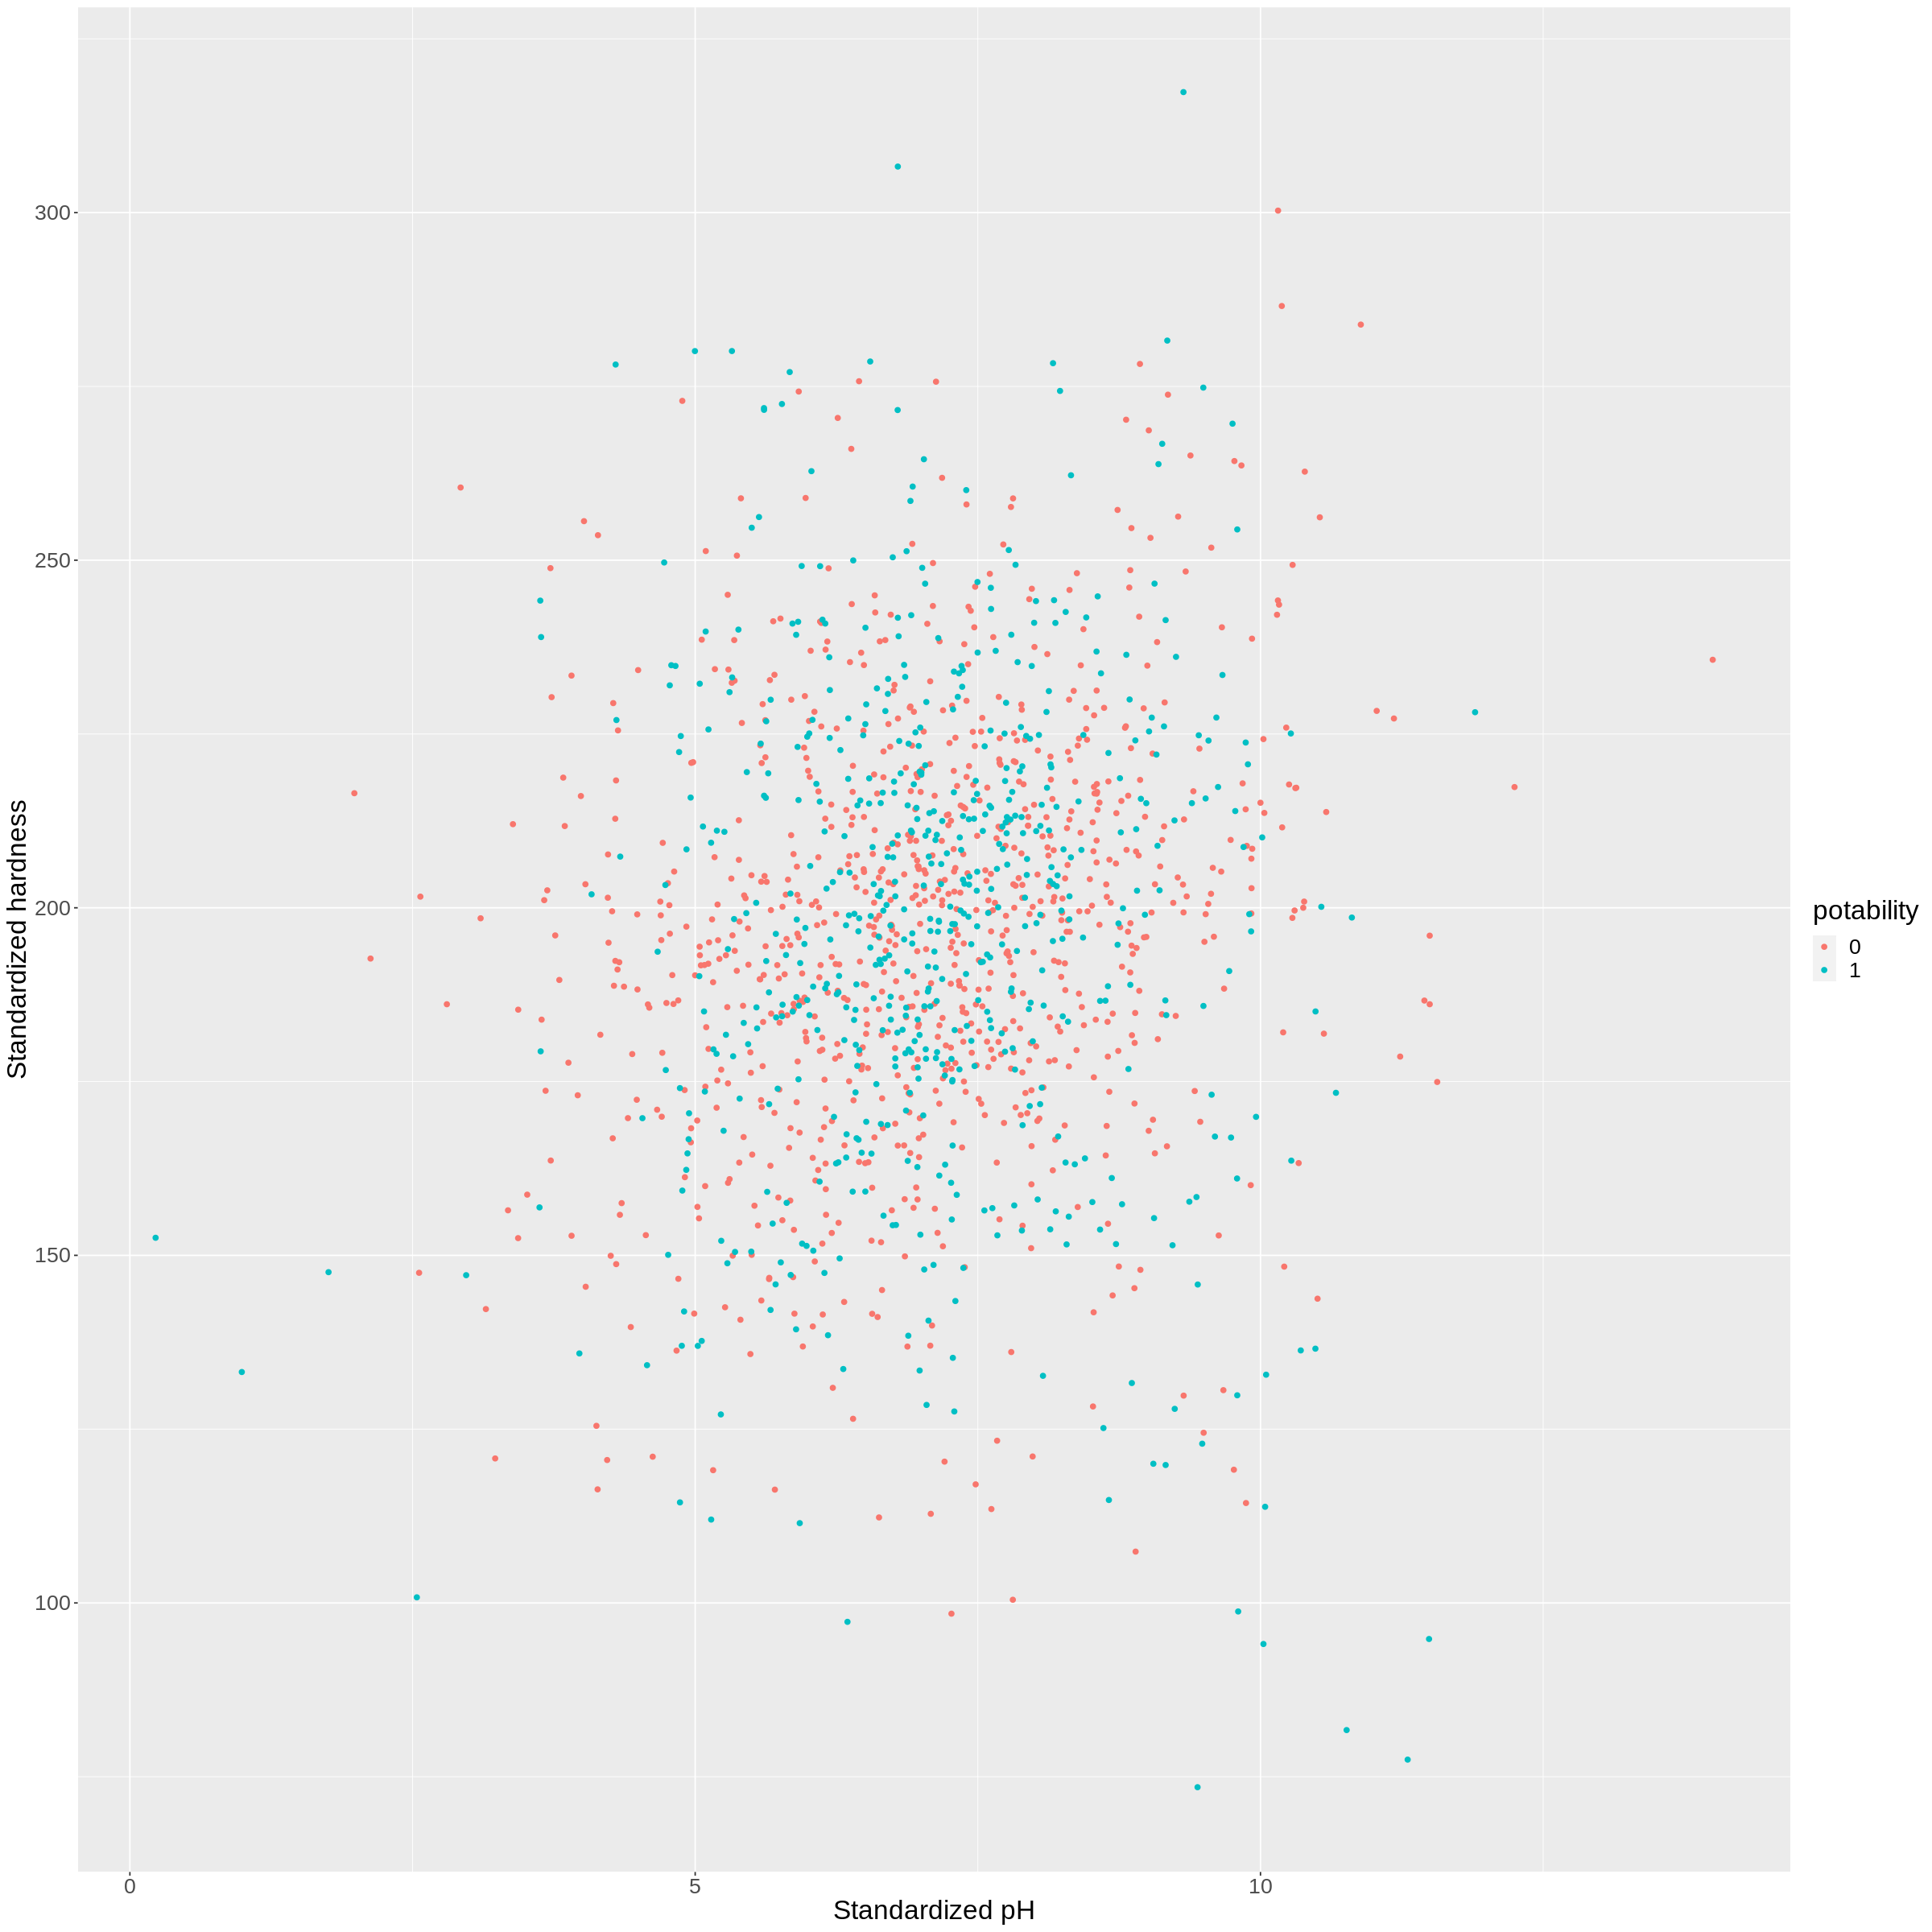

In [23]:
# #7. SCALE TRAINING DATA USING SCALE()
# water_train_scaled_2 <- water_train |> #scale all predictors using the scale() function
#     select(-potability) |>
#     scale(center = TRUE, scale = TRUE) |>
#     bind_cols(potability = water_train$potability)

#8. PLOT TRAINING DATA IN A SCATTERPLOT COMPARING THE DISTRIBUTION ACCORDING TO TWO SELECTED PREDICTORS
water_train_scatterplot <- water_train |> #scatterplot comparing two predictors--in this case, pH and hardness, standardized
    ggplot(aes(x = ph, y = hardness, color = potability)) +
    geom_point() +
    labs(x = "Standardized pH", y = "Standardized hardness") +
    theme(text = element_text(size = 20))

water_train_scatterplot

<center> (Figure 9: Distribution of mean values of water potability predictors) </center>

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6114393,10,0.007923062,Preprocessor1_Model1
1,roc_auc,binary,0.5859107,10,0.008206905,Preprocessor1_Model1
3,accuracy,binary,0.6147064,10,0.006599658,Preprocessor1_Model2
3,roc_auc,binary,0.6174035,10,0.009014627,Preprocessor1_Model2
5,accuracy,binary,0.6087417,10,0.014315208,Preprocessor1_Model3
5,roc_auc,binary,0.6222981,10,0.015268014,Preprocessor1_Model3
8,accuracy,binary,0.6173731,10,0.014508561,Preprocessor1_Model4
8,roc_auc,binary,0.6239772,10,0.016943146,Preprocessor1_Model4
9,accuracy,binary,0.6319514,10,0.016662969,Preprocessor1_Model5


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.6332892,10,0.014652095,Preprocessor1_Model7
13,accuracy,binary,0.6319868,10,0.012031164,Preprocessor1_Model8
14,accuracy,binary,0.6319868,10,0.012031164,Preprocessor1_Model9
9,accuracy,binary,0.6319514,10,0.016662969,Preprocessor1_Model5
10,accuracy,binary,0.6319514,10,0.016662969,Preprocessor1_Model6
8,accuracy,binary,0.6173731,10,0.014508561,Preprocessor1_Model4
3,accuracy,binary,0.6147064,10,0.006599658,Preprocessor1_Model2
1,accuracy,binary,0.6114393,10,0.007923062,Preprocessor1_Model1
5,accuracy,binary,0.6087417,10,0.014315208,Preprocessor1_Model3


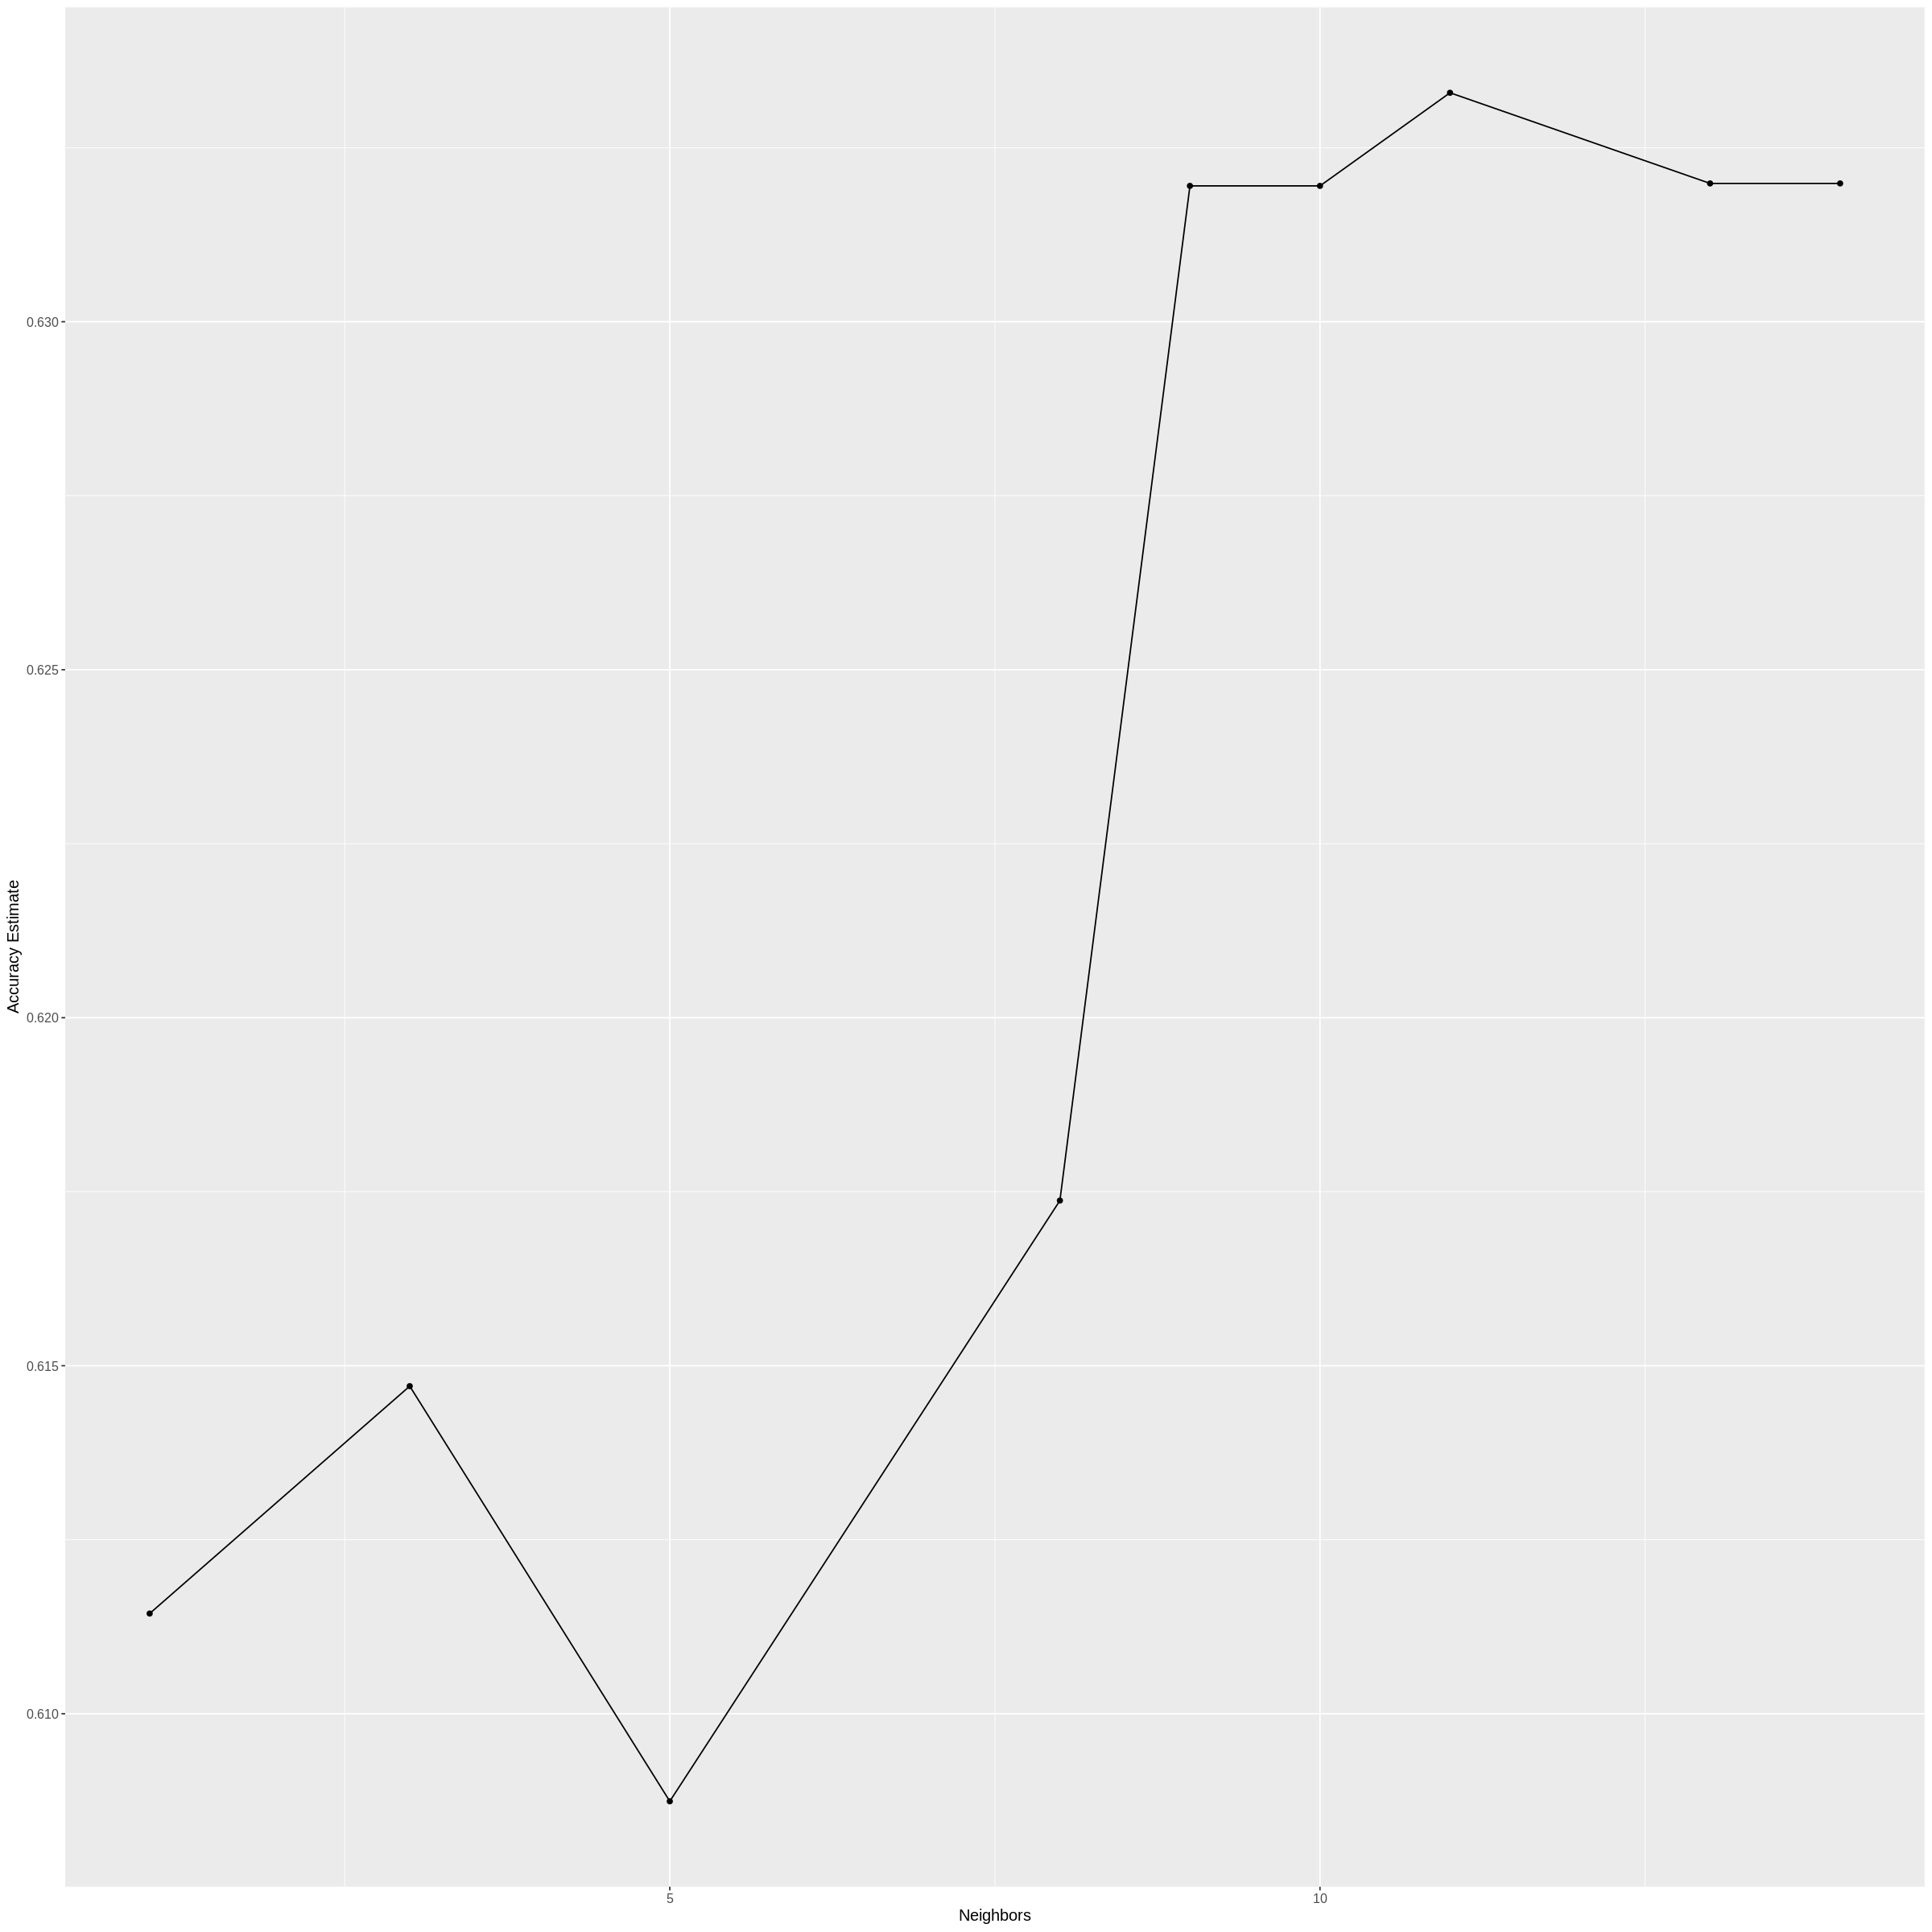

In [24]:
# # Specify the model for v-fold cross validation
# # neighbors = tune() is used when we want to test the accuracies for a range of different parameter values.
# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#   set_engine("kknn") |>
#   set_mode("classification")

# set.seed(1)
# knn_results <- workflow() |>
#   add_recipe(cancer_recipe) |>
#   add_model(knn_spec) |>
#   tune_grid(resamples = cancer_vfold, grid = 10) |>
#   collect_metrics()
# knn_results

# accuracies <- knn_results |>
#   filter(.metric == "accuracy")

# ---------------------------------------------------------------------------------------------
# Now check for most optimal accuracy (usually the highest and most stable one) by plotting them
# ---------------------------------------------------------------------------------------------

# # Plot of k values against their respective accuracies
# cross_val_plot <- accuracies |> 
#     ggplot(aes(x = neighbors, y = mean)) +
#     geom_point() +
#     geom_line() +
#     labs(x = "Neighbors", y = "Accuracy Estimate") +
#     theme(text = element_text(size = 20))
set.seed(2023)


water_vfold <- vfold_cv(water_train, v = 10, strata = potability)

water_recipe <- recipe(potability ~ ., data = water_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = water_vfold, grid = 10) |>
    collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))

accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

In [25]:
# ##(7)##
# knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
#   set_engine("kknn") |>
#   set_mode("classification")

# cancer_fit <- workflow() |>
#   add_recipe(cancer_recipe) |>
#   add_model(knn_best_spec) |>
#   fit(data = cancer_train)

# ##(8)##
# # Get the prediction column
# cancer_predictions <- predict(cancer_fit, cancer_test) |> 
#     bind_cols(cancer_test)

# # Compare the accuracy of predictions to the true values in the test set
# cancer_acc <- cancer_predictions |> 
#     metrics(truth = Classes, estimate = .pred_class) |> 
#     select(.metric, .estimate) |> 
#     head(1)

# # Compare the predictions to the true values in a confusion matrix
# cancer_cm <- cancer_predictions |> 
#     conf_mat(truth = Classes, estimate = .pred_class)

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

water_fit <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = water_train)

water_predictions <- predict(water_fit, water_test) |>
    bind_cols(water_test)

water_acc <- water_predictions |>
    metrics(truth = potability, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

water_cm <- water_predictions |>
    conf_mat(truth = potability, estimate = .pred_class)

water_predictions
water_acc
water_cm

.pred_class,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,8.316766,214.3734,22018.417,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
0,5.584087,188.3133,28748.688,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0
0,10.223862,248.0717,28749.717,7.513408,393.6634,283.6516,13.789695,84.60356,2.672989,0
0,6.514415,198.7674,21218.703,8.670937,323.5963,413.2905,14.900000,79.84784,5.200885,0
0,3.445062,207.9263,33424.769,8.782147,384.0070,441.7859,13.805902,30.28460,4.184397,0
1,10.433291,117.7912,22326.892,8.161505,307.7075,412.9868,12.890709,65.73348,5.057311,0
0,9.267188,198.6144,24683.724,6.110612,328.0775,396.8769,16.471969,30.38331,4.324005,0
0,5.331940,194.8741,16658.877,7.993830,316.6752,335.1204,10.180514,59.57271,4.434820,0
1,7.145772,238.6899,28780.340,6.814029,385.9757,332.0327,11.093163,66.13804,5.182591,0


.metric,.estimate
<chr>,<dbl>
accuracy,0.638171


          Truth
Prediction   0   1
         0 257 139
         1  43  64